In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import arviz as az
import scipy.stats as sps
import requests

sns.set()

In [ ]:
# https://www.healthknowledge.org.uk/public-health-textbook/research-methods/1a-epidemiology/years-lost-life
# https://data.oecd.org/healthstat/potential-years-of-life-lost.htm

#### DEPENDS ON RUNNING stratified...ipynb to produce pkl-files below ###

In [ ]:
strata_abs_deaths = pd.read_pickle('strata_abs_deaths.pkl')
strata_abs_deaths

In [ ]:
strata_abs_pop = pd.read_pickle('strata_abs_pop.pkl')
strata_abs_pop

In [ ]:
death_rate = strata_abs_deaths.div(strata_abs_pop ,axis=0)
death_rate

In [ ]:
std_pop = strata_abs_pop.loc[2010]
std_pop

In [ ]:
# age adjusted deaths, std year = 2010

age_adjusted_deaths = death_rate * std_pop
age_adjusted_deaths

In [ ]:
# OECD defines 74 as std death age

median_age_of_death = 70

age_grps = np.array([64,79,89,90])

lyl = median_age_of_death - age_grps
lyl

In [ ]:
life_years_lost_per_age = age_adjusted_deaths * lyl
life_years_lost_per_age

In [ ]:
life_years_lost_per_age = life_years_lost_per_age.applymap(lambda x : 0 if x < 0 else x)
life_years_lost_per_age

In [ ]:
LYL_total = life_years_lost_per_age.sum(axis=1)
LYL_total

In [ ]:
LYL_total.plot(kind='bar',
               figsize=(18,12),
               title='SWEDEN Age Adj. Estimate Life-Years-Lost 2001-2020\n\nASSUMPTIONS:\n1) 2020 pop grows as 2018-2019\n' \
               '2) deaths 2020 grow proportionally YTD\n[Standard Population : 2010, Life Expectancy: {} (OECD STD)]'.format(
                   median_age_of_death),
               color='r')

text = r'LYL $estimated$ with the 4 age grps [64,79,89,90+]  avail. for prel. 2020 data' 
text2 = 'see https://data.oecd.org/healthstat/potential-years-of-life-lost.htm'

plt.ylabel('Rough Estimate Life Years Lost')

plt.text(10,80000,text)
plt.text(10,75000,text2)

plt.savefig('LYL_{}.jpg'.format(median_age_of_death),format='jpg',dpi=400)

In [ ]:
LYL_total_per_m = LYL_total / (std_pop.sum() / 1e6)
LYL_total_per_m

In [ ]:
LYL_total_per_m.plot(kind='bar',
               figsize=(18,12),
               title='SWEDEN Age & Pop. Adj, Life-Years-Lost\nASSUMPTIONS:\n1) 2020 pop grows as 2018-2019\n' \
               '2) deaths 2020 grow proportionally YTD\n[Standard Population : 2010, Life Expectancy: {}]'.format(
                   median_age_of_death),
               color='r')

plt.savefig('LYL_per_m_{}.jpg'.format(median_age_of_death),format='jpg',dpi=400)

In [ ]:
# constructed example using official SCB mortality data

scb_mortality = pd.read_pickle('mortality.pkl')
scb_mortality

In [ ]:
scb_population = pd.read_pickle('population.pkl')
scb_population

In [ ]:
standard_population = scb_population[2010]
standard_population

In [ ]:
standard_deaths_age_grp = scb_mortality.mul(standard_population,axis=0)
standard_deaths_age_grp

In [ ]:
age_adjusted_deaths = standard_deaths_age_grp.sum()
age_adjusted_deaths


In [ ]:
age_adjusted_deaths.plot(kind='bar',figsize=(18,12))

In [ ]:
life_expectancy = median_age_of_death

years_lost_per_age = pd.Series(range(0,100,5),index=standard_deaths_age_grp.index)
years_lost_per_age = life_expectancy - years_lost_per_age
years_lost_per_age

In [ ]:
LYL_per_age = standard_deaths_age_grp.mul(years_lost_per_age,axis=0)
LYL_per_age = LYL_per_age.applymap(lambda x : 0 if x < 0 else x)
LYL_per_age

In [ ]:
LYL = LYL_per_age.sum()
LYL

In [ ]:
LYL.plot(kind='bar',figsize=(18,12))

In [ ]:
plt.figure(figsize=(18,12))
title = 'SWEDEN Life Years Lost, official age groups vs preliminary FHM/SCB covid reporting age groups\n\n' \
'ASSUMPTIONS:\n1) Life Expectancy: {}\nPopulation 2020 grows as 2018->2019\n2)'.format(life_expectancy) + \
' Full Year 2020 deaths grow proportionally YTD\n' \
'DataSource: SCB.se'

plt.title(title)
plt.plot(LYL,'o--',label='calc. from SCB official 5 year strata')
plt.plot(LYL_total,'o--',label='calc using age groups [64,79,89,90+]')
_= plt.xticks(LYL_total.index)
plt.ylabel('Life Years Lost')

plt.legend(loc='upper right')

In [ ]:
lyls = pd.concat([LYL,LYL_total],axis=1)
lyls.columns=['LYL_SCB','LYL__COVID_prel']
lyls

In [ ]:
lyls.corr()

In [ ]:
# manipulate mortality for the young 

mortality_fake = mortality.copy()
mortality_fake.loc['1-4' : '25-29',2019] = mortality.loc['1-4' : '25-29',2019] * 2
mortality_fake

In [ ]:
fake_pop_adj_per_grp = mortality_fake.mul(standard_population,axis=0)
fake_pop_adj_per_grp

In [ ]:
fake_pop_adj_per_grp.sum()

In [ ]:
LYL_fake = fake_pop_adj_per_grp.mul(years_lost_per_age,axis=0)
LYL_fake = LYL_fake.applymap(lambda x : 0 if x < 0 else x)
LYL_fake

In [ ]:
LYL_fake_tot = LYL_fake.sum()
LYL_fake_tot

In [ ]:
colors = ['b'] * 18
colors.append('r')

fig,axes = plt.subplots(2,1,sharex=True,sharey=True,figsize=(18,12))

LYL.plot(kind='bar',ax=axes[0],title='SWEDEN Life-Years-Lost 2001-2020')

LYL_fake_tot.plot(kind='bar',color=colors,ax=axes[1],
                  title='SIMULATED DATA for 2019: Life-Years-Lost with DOUBLED mortality for ages 1-29, year 2019')

axes[0].set_ylabel('life years lost')
axes[1].set_ylabel('life years lost')

plt.savefig('LYL_simulated_double_mortality_1_29.jpg',format='jpg',dpi=400)

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18],
       [ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27],
       [ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36]])

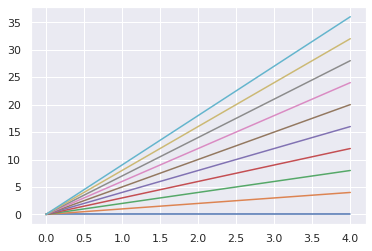

In [477]:

x = np.arange(5)
c = np.arange(10)
_= plt.plot(x,x[:,np.newaxis]*c)
x[:,np.newaxis]*c
